# Building a Multivariate Dataset From Your Model Objects

The purpose of this Notebook is to use the Disease Propogation Objects to build a dataset testing variations in the mitigation methods. The output of this Notebook will be a csv file that contains the results from multple runs of the various interactions. 

## Steps:
1. Add the Person, Population, and Community Objects
2. Create a function that allows the Community object interventions parameters to be tested over the range of 0 to that number (Ex. Population Size, Number of Interactions, Percentage Masked). **NOTE: make sure to add any custom interventions you may have added.**
3. Alter the code to ouput to a csv file
4. Run the simulation to create your dataset.


## Step 1. Add our Person, Population, and Community Class Objects

#### Person Object

In [1]:
# Import libraries
import numpy as np
import random

# Person Object AKA Joe
class Person(object):
    def __init__(self, 
                 default_infection_rate_person = 10):
        self.status = "Susceptible"
        self.days_sick = 0
        self.infection_rate = default_infection_rate_person
        self.Interaction = []
    
    def set_infection_rate(self, new_rate):
        self.infection_rate = new_rate
    
    def infect(self, number_of_days_sick):
        self.status = "Infected"
        self.days_sick = number_of_days_sick
    
    def recover(self):
        self.status = "Recovered"
        self.days_sick = 0
    
    def update(self):
        if (self.status == "Susceptible"):
            self.roll_for_infection()
            
        elif (self.status == "Infected"):            
            self.days_sick = self.days_sick - 1
            if (self.days_sick <= 0):
                self.recover()
    
    def update_days_sick(self):
        if (self.status == "Infected"):            
            self.days_sick = self.days_sick - 1
            if (self.days_sick <= 0):
                self.recover()
            
    def roll_for_infection(self):
        is_sick = (random.randint(0,101) < self.infection_rate)
        if (is_sick):
            self.infect(4)

#### Population Community

In [14]:
from numpy.random.mtrand import random_sample
# Population Object
class Population:
    def __init__(self, 
                 default_number_of_people=1000, 
                 default_interactions=10, 
                 default_days_sick=5, 
                 default_infection_rate = 10,
                 default_max_hosp = 0.8,
                 default_safe_hosp = 0.4,
                 default_beds = 360,
                 #default_date_CB = 60,
                 #default_date_AB = 390,
                 default_max_entries=100,
                 default_max_exits=100):
        self.People = []
        self.population_count = default_number_of_people
        self.number_of_interactions = default_interactions
        self.max_days_sick = default_days_sick
        self.infection_rate_pop = default_infection_rate
        self.max_hospitalization = default_max_hosp
        self.safe_rate_hosp = default_safe_hosp
        #self.date_CB = default_date_CB # date when borders were close
        #self.date_AB = default_date_AB #date when borders were open 
        self.max_entries = default_max_entries
        self.max_exits = default_max_exits # percentage
        self.open_borders = True
        self.beds = default_beds
        
        ##build our population
        patient_Zero = Person(default_infection_rate_person = self.infection_rate_pop)
        patient_Zero.infect(self.max_days_sick)
        
        self.People.append(patient_Zero)
        
        for i in range(0,self.population_count):
            p = Person(default_infection_rate_person = self.infection_rate_pop)
            self.People.append(p)
            
    def number_of_sick(self):
        sick_Count = 0
        for j in self.People:
            if (j.status == "Infected"):
                sick_Count = sick_Count + 1
                
        return sick_Count
    
    def number_of_recovered(self):
        recovered_Count = 0
        for j in self.People:
            if (j.status == "Recovered"):
                recovered_Count = recovered_Count + 1
        
        return recovered_Count
    
    def number_of_susceptible(self):
        susceptible_Count = 0
        for j in self.People:
            if (j.status == "Susceptible"):
                susceptible_Count = susceptible_Count + 1
                
        return susceptible_Count

    def set_infection_rate_pop(self, new_rate):
        self.infection_rate = new_rate

    def set_max(self, new_max_entries, new_max_exits):
        self.max_entries = new_max_entries
        self.max_exits = new_max_exits
        
    def set_state_of_borders(self, hospitalization):
        if (hospitalization <=self.safe_rate_hosp*self.beds):
            self.open_borders = True
            
    def get_number_beds(self):
        return int(self.beds*self.max_hospitalization)
    
    ## Here's the brains of the Population class (and our code)
    ## the update will be ran everyday (meaning, every iteration of our while loop)
    ## build interaction tables (who interacted with whom)
    ## if marked sick they must roll to see if (one per interaction)
    ## if I interacted with 10 people, each of them must roll and vice versa if they
    ## they were marked as infected
    def update(self, hospitalizations):
        ## people who are might get sick
        might_Get_Sick = []

        #entrances and exits of the country
       # if (day < self.date_CB) or (day >= self.date_AB):
        if (hospitalizations < self.max_hospitalization) and (self.open_borders):
            todays_exits = random.randint(0,self.max_exits)
            self.People = random.sample(self.People, len(self.People) - todays_exits)
            
            todays_entries = random.randint(0,self.max_entries)            
            for i in range(0,todays_entries):
                p = Person(default_infection_rate_person = self.infection_rate_pop)
                self.People.append(p)
                
            #print ("Hospitalization rate", hospitalizations, "Todays entries:", todays_entries, 
            #       "Todays exits:", todays_exits, "Todays total population", len(self.People))
        
        for person in self.People:
            
            #clear out your interactions per day
            person.Interaction = []
            
            if self.number_of_interactions > len(self.People):
                self.number_of_interactions = len(self.People)
            
            ##These are the n number of people that you interact with
            for i in range(0, self.number_of_interactions):
                r = random.choice(self.People)
                n = self.People.index(r)
                person.Interaction.append(n)
                
            ##if "person" is Infected, every single person they interacted with might get sick
            if (person.status == "Infected"):
                person.update_days_sick()
                
                for m in person.Interaction:
                    if (self.People[m].status == "Susceptible"): #only susceptible people can get sick
                        might_Get_Sick.append(self.People[m])
            
            ##if "person" is susceptible and they interact w/ someone who is "infected" 
            ##person gets added to the "might get sick"
            if (person.status == "Susceptible"):
                for m in person.Interaction:
                    #n = self.People.index(m)
                    if (self.People[m].status == "Infected"):
                        might_Get_Sick.append(person)
            
        ##Now! We're going to roll through our "Might Get Sick" and they each roll a die
        ##this is only a list of susceptible people
        for p in might_Get_Sick:
            p.roll_for_infection()

In [ ]:
myCommunity = Population(default_number_of_people=1000, 
                         default_interactions=10, 
                         default_days_sick=5, 
                         default_infection_rate = 10,
                         default_max_hosp = 0.8,
                         default_safe_hosp = 0.4,   
                         default_max_entries=100,
                         default_max_exits=100)

In [ ]:
myCommunity.update(0.9)

In [ ]:
print(len(myCommunity.People))

#### Person Community

In [24]:
# Define the Community
# Population( size_of_population, number_of_interactions, percentage_wearing_masks)
myCommunity = Population(default_number_of_people=1000, 
                         default_interactions=10, 
                         default_days_sick=5, 
                         default_infection_rate = 10,
                         default_max_hosp = 0.6,
                         default_safe_hosp = 0.3, 
                         default_beds = 100)

day = 0
max_entries_ACB = 5
max_exits_ACB = 5

my_plot = []
number_sick = myCommunity.number_of_sick()

while (number_sick > 0):
    number_sick = myCommunity.number_of_sick()
    number_recovered = myCommunity.number_of_recovered()
    
    my_plot.append([day, number_sick, number_recovered])
    
    hospitalization = number_sick*(.14)
    beds = myCommunity.get_number_beds()
    
    if (hospitalization >= beds):
        myCommunity.open_borders = False
        print('Day', day, 'borders are closed')
        
    if (hospitalization < beds) and (not myCommunity.open_borders):
        myCommunity.set_state_of_borders(hospitalization )
        print('Day', day, 'borders are opened')
        
    #if (myCommunity.date_CB <= day < myCommunity.date_AB):
    #    myCommunity.set_infection_rate_pop(infection_rate_DCB)
    #    myCommunity.set_max(0, 0)
        
    #if (day > myCommunity.date_AB):
    #    myCommunity.set_infection_rate_pop(infection_rate_ACB)
    #    myCommunity.set_max(max_entries_ACB, max_exits_ACB)  
    
    #infection_rate = myCommunity.infection_rate_pop
    
    #if (myCommunity.percentage_masked > 0):
    #    print ("day:", day, "Number of sick:", number_sick, "Hosptalized:", number_sick*(.04), "Sick Mask Wearers:", number_masked_sick, "Mask Wearers:", number_masked)
    #else:
    #    print ("day:", day, "Number of sick:", number_sick)
    print ("Day:", day, 
           "Number of sick:", number_sick, 
           "Hosptalized:", int(hospitalization), 
           "Number of recovered", number_recovered)
    print ("Todays total population", len(myCommunity.People))
   
    day = day+1
    myCommunity.update(hospitalization)

#print ("day:", day, "Number of sick:", myCommunity.number_of_sick())
print ("Number recovered:", myCommunity.number_of_recovered())
print ("Number susceptible:", myCommunity.number_of_susceptible())

Day: 0 Number of sick: 1 Hosptalized: 0 Number of recovered 0
Todays total population 1001
Day: 1 Number of sick: 3 Hosptalized: 0 Number of recovered 0
Todays total population 1052
Day: 2 Number of sick: 5 Hosptalized: 0 Number of recovered 0
Todays total population 1062
Day: 3 Number of sick: 17 Hosptalized: 2 Number of recovered 0
Todays total population 1062
Day: 4 Number of sick: 45 Hosptalized: 6 Number of recovered 0
Todays total population 1062
Day: 5 Number of sick: 122 Hosptalized: 17 Number of recovered 3
Todays total population 1062
Day: 6 Number of sick: 305 Hosptalized: 42 Number of recovered 5
Todays total population 1062
Day 7 borders are closed
Day: 7 Number of sick: 603 Hosptalized: 84 Number of recovered 17
Todays total population 1062
Day 8 borders are closed
Day: 8 Number of sick: 859 Hosptalized: 120 Number of recovered 45
Todays total population 1062
Day 9 borders are closed
Day: 9 Number of sick: 903 Hosptalized: 126 Number of recovered 125
Todays total populati

# 2. Make a function that allows the interventions to be easily tested

Create a function that allows the Community object interventions parameters to be tested over the range of 0 to that number (Ex. Population Size, Number of Interactions, Percentage Masked). 

In [25]:
def myCommunityTests(pop_test, max_hosp_test, safe_hosp_test, beds_test):
    myCommunity = Population(default_number_of_people=pop_test,
                         default_max_hosp = max_hosp_test,
                         default_safe_hosp = safe_hosp_test, 
                         default_beds = beds_test)

    day = 0
    my_plot = []
    number_sick = myCommunity.number_of_sick()

    while (number_sick > 0):
        number_sick = myCommunity.number_of_sick()
        number_recovered = myCommunity.number_of_recovered()

        hospitalization = number_sick*(.14)
        beds = myCommunity.get_number_beds()

        if (hospitalization >= beds):
            myCommunity.open_borders = False
            print('Day', day, 'borders are closed')

        if (hospitalization < beds) and (not myCommunity.open_borders):
            myCommunity.set_state_of_borders(hospitalization )
            print('Day', day, 'borders are opened')

        day = day+1
        myCommunity.update(hospitalization)

        my_plot.append([day, number_sick, number_recovered, hospitalization, beds, len(myCommunity.People),myCommunity.open_borders])
        
        return my_plot
        print ("Day:", day, 
           "Number of sick:", number_sick, 
           "Hosptalized:", int(hospitalization), 
           "Number of recovered", number_recovered)
        print ("Todays total population", len(myCommunity.People))

In [42]:
myCommunityTests(3000, 0.8, 0.4, 100)

Day: 1 Number of sick: 1 Hosptalized: 0 Number of recovered 0
Todays total population 2966
Day: 2 Number of sick: 4 Hosptalized: 0 Number of recovered 0
Todays total population 2997
Day: 3 Number of sick: 12 Hosptalized: 1 Number of recovered 0
Todays total population 2997
Day: 4 Number of sick: 35 Hosptalized: 4 Number of recovered 0
Todays total population 2997
Day: 5 Number of sick: 103 Hosptalized: 14 Number of recovered 0
Todays total population 2997
Day: 6 Number of sick: 283 Hosptalized: 39 Number of recovered 4
Todays total population 2997
Day 6 borders are closed
Day: 7 Number of sick: 736 Hosptalized: 103 Number of recovered 12
Todays total population 2997
Day 7 borders are closed
Day: 8 Number of sick: 1583 Hosptalized: 221 Number of recovered 35
Todays total population 2997
Day 8 borders are closed
Day: 9 Number of sick: 2393 Hosptalized: 335 Number of recovered 103
Todays total population 2997
Day 9 borders are closed
Day: 10 Number of sick: 2609 Hosptalized: 365 Number of

In [ ]:
vec = 

## 3. Alter the code to ouput to a csv file

In [46]:
# Alter the myCommunityTests function to ouput wanted data to a csv

#Ex: Population_Size, Number_Interactions, Total_Days, Number_Recovered, Number_Suceptible, Max_Sick, Max_Hospitalized
import pandas as pd

def myCommunityTests_toDict(pop_test, max_hosp_test, safe_hosp_test, beds_test, hospitalization_rate =0.14):
    # Population(size_of_population, number_of_interactions,infection_rate_pop)
    myCommunity = Population(default_number_of_people = pop_test,
                         default_max_hosp = max_hosp_test,
                         default_safe_hosp = safe_hosp_test, 
                         default_beds = beds_test)
    day = 0
    my_plot = []
    simulation_sumary = {
        "Population_Size" : pop_test,
        "Maximum_Percentage_Hospitalization" : max_hosp_test,
        "Safe_Percentage_Hospitalization" : safe_hosp_test,
        "Number_of_beds" : beds_test,
        "Hospitalization_Rate" : hospitalization_rate
    }
    
    number_sick = myCommunity.number_of_sick()

    while (number_sick > 0):
        number_sick = myCommunity.number_of_sick()
        number_recovered = myCommunity.number_of_recovered()

        hospitalization = number_sick*(.14)
        beds = myCommunity.get_number_beds()

        if (hospitalization >= beds):
            myCommunity.open_borders = False
            print('Day', day, 'borders are closed')

        if (hospitalization < beds) and (not myCommunity.open_borders):
            myCommunity.set_state_of_borders(hospitalization )
            print('Day', day, 'borders are opened')

        day = day+1
        myCommunity.update(hospitalization)

        my_plot.append([day, number_sick, number_recovered, hospitalization, beds, len(myCommunity.People), myCommunity.open_borders])
               
    dataset = pd.DataFrame(my_plot, columns= ['day', 'number_sick', 'number_recovered', 'hospitalized','beds', 'population', 'Open_borders'])
    #print ("day:", day, "Number of sick:", myCommunity.number_of_sick())
    #print ("Number recovered:", myCommunity.number_of_recovered())
    simulation_sumary["recovered"] = myCommunity.number_of_recovered()
    #print ("Number susceptible:", myCommunity.number_of_susceptible())
    simulation_sumary["susceptible"] = myCommunity.number_of_susceptible()
    #print (dataset.head())
    simulation_sumary["total_days"] = dataset["day"].max()
    simulation_sumary["max_sick"] = dataset["number_sick"].max()
    simulation_sumary["max_hospitalized"] = dataset["hospitalized"].max()
    simulation_sumary["max_population"] = dataset["population"].max()
    simulation_sumary["count_open_borders"] = dataset["Open_borders"].sum()
    
    print(simulation_sumary)
    #return simulation_sumary
    return dataset
    
    


In [60]:
df = myCommunityTests_toDict(3000, 0.9, 0.4, 21)

Day 4 borders are closed
Day 5 borders are closed
Day 6 borders are closed
Day 7 borders are closed
Day 8 borders are closed
Day 9 borders are closed
Day 10 borders are closed
Day 11 borders are closed
Day 12 borders are closed
Day 13 borders are opened
{'Population_Size': 3000, 'Maximum_Percentage_Hospitalization': 0.9, 'Safe_Percentage_Hospitalization': 0.4, 'Number_of_beds': 21, 'Hospitalization_Rate': 0.14, 'recovered': 2934, 'susceptible': 117, 'total_days': 17, 'max_sick': 2719, 'max_hospitalized': 380.66, 'max_population': 3137, 'count_open_borders': 8}


In [61]:
df

,day,number_sick,number_recovered,hospitalized,beds,population,Open_borders
0,1,1,0,0.14,18,3045,True
1,2,6,0,0.84,18,3102,True
2,3,22,0,3.08,18,3102,True
3,4,68,0,9.52,18,3102,True
4,5,209,0,29.26,18,3102,False
5,6,560,6,78.40,18,3102,False
6,7,1325,22,185.50,18,3102,False
7,8,2311,68,323.54,18,3102,False
8,9,2719,209,380.66,18,3102,False
9,10,2505,566,350.70,18,3102,False


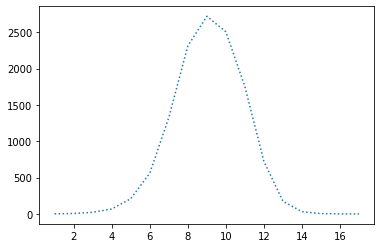

In [62]:
import matplotlib.pyplot as plt

plt.plot(df['day'],df['number_sick'], linestyle = 'dotted')
plt.show()

In [52]:
plt.savefig("output.jpg") 

<Figure size 432x288 with 0 Axes>

# 4. Now lets run our simulation with a range of values for our interventions

In [ ]:
import csv

pop_test  = 3000
maximum_interaction 

# Name of the output csv file
filename = "mycsvfile.csv"


for i in range(0, maximum_interactions, 1):
     for m in range(0, maximum_mask_percentage, 1):
        
          sim_data = myCommunityTests_toDict(test_population, i, m, hospital_rate)
          print(sim_data)
    
          if (i == 0 and m == 0):
             with open(filename, 'w') as f:  
                 w = csv.DictWriter(f, sim_data.keys())
                 w.writeheader()
          else:
              with open(filename, 'a') as f:  # You will need 'wb' mode in Python 2.x
                w = csv.DictWriter(f, sim_data.keys())
                w.writerow(sim_data)

  
        
       